In [669]:
import heapq
import logging
import random
from itertools import chain

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from networkx.algorithms import bipartite
from networkx.drawing.layout import bipartite_layout
from networkx.drawing.nx_pylab import draw_kamada_kawai as draw

# drawing graphs using matplotlib
from networkx.drawing.nx_pylab import draw_networkx
from tqdm import tqdm

logger = logging.getLogger(__name__)
logger.setLevel(logging.ERROR)

In [670]:
def parse_nauty_edges(filename):
    """Parses an edge list file from nauty_gen into NetworkX graphs."""
    graphs = []

    with open(filename, "r") as file:
        for line in file:
            graph = nx.Graph()
            index, edges_str = line.strip().split(": ")
            edges = edges_str.split("; ")

            for edge in edges:
                nodes = tuple(map(int, edge.split(",")))
                graph.add_edge(*nodes)

            graphs.append(graph)

    return graphs

In [671]:
def plot_graphs(G_valid, A_nodes, B_nodes, bipartite=False):
    """Plots the four graphs side by side: Bipartite G, General Layout, Projected G_A, Projected G_B."""
    subplots = 3 + bipartite
    fig, axes = plt.subplots(1, subplots, figsize=(20, 5))

    # Plot 3: Projected G_A
    G_A_projected = nx.bipartite.projected_graph(G_valid, A_nodes)
    plt.sca(axes[0])
    plt.title("Projected G_A")
    draw(G_A_projected, node_color="red", with_labels=True, edge_color="black")

    # Plot 1: Bipartite Graph
    if bipartite:
        plt.sca(axes[1])
        pos = bipartite_layout(G_valid, A_nodes)
        color_map = ["red" if node in A_nodes else "green" for node in G_valid.nodes()]
        plt.title("Bipartite G")
        nx.draw(
            G_valid, pos, node_color=color_map, with_labels=True, edge_color="black"
        )

    # Plot 2: General Layout (Reconstructed G)
    plt.sca(axes[1 + bipartite])
    color_map = ["red" if node in A_nodes else "green" for node in G_valid.nodes()]
    plt.title("Reconstructed G")
    draw(G_valid, node_color=color_map, with_labels=True, edge_color="black")

    # Plot 4: Projected G_B
    G_B_projected = nx.bipartite.projected_graph(G_valid, B_nodes)
    plt.sca(axes[2 + bipartite])
    plt.title("Projected G_B")
    draw(G_B_projected, node_color="green", with_labels=True, edge_color="black")

    plt.tight_layout()
    plt.show()

In [ ]:
def _get_induced_projected_edges(G, a, b):
    # we want to return all edges (ai, aj)
    # NOTE use set() so order doesn't matter
    return set((a, ax) for ax in G.neighbors(b))


def _check_induced_valid(G, G_A_projected, a, b):
    # check that induced projected edges are valid
    # i.e. for all (ai, aj) in G_A_projected, (ai, aj) is in G
    projected_edges = _get_induced_projected_edges(G, a, b)
    return all(edge in G_A_projected.edges() for edge in projected_edges)


# def _count_removed_projected_edges(G, G_A_stack, a, b):
#     projected_edges = _get_induced_projected_edges(G, a, b)
#     # return count of projected_edges that are in G_A_stack
#     return sum(1 for edge in projected_edges if edge in G_A_stack)


def _get_candidate_edges(G, A_nodes, B_nodes, max_degree_A, max_degree_B):
    degA, degB = bipartite.degrees(G, A_nodes)
    # return all sets (a, b) where degA[a] < max_degree_A and degB[b] < max_degree_B
    # and (a,b) is not an edge in G
    return (
        set((a, b))
        for a in A_nodes
        for b in B_nodes
        if degA[a] < max_degree_A and degB[b] < max_degree_B and not G.has_edge(a, b)
    )


def construct_bipartite_graph(G_A_projected, max_degree_A, max_degree_B):
    assert max_degree_B >= 2
    # working copy, delete edges from this as satisfied
    G_A_projected_stack = [set((i, j)) for i, j in G_A_projected.edges()]

    # Define A and B sets
    _num_A = len(G_A_projected.nodes())
    A_nodes = list(G_A_projected.nodes())
    # B_nodes = list(range(1 + _num_A, 1 + _num_A + num_B))  # NOTE networkx use 1-indexes
    # Start with two B nodes: one gets an initial edge, one remains empty
    B_nodes = [1 + _num_A, 2 + _num_A]

    # Initialize an empty bipartite graph G
    G_rebuilt = nx.Graph()
    G_rebuilt.add_nodes_from(A_nodes, bipartite=0)
    G_rebuilt.add_nodes_from(B_nodes, bipartite=1)

    # Start by popping trivial first edge from stack
    ai, aj = G_A_projected_stack.pop()
    b = B_nodes[0]
    G_rebuilt.add_edge(ai, b)
    G_rebuilt.add_edge(aj, b)

    # Step 1, satisfy the projection
    while G_A_projected_stack:
        ai, aj = G_A_projected_stack.pop()

        # first check if this has already been resolved
        if (ai, aj) in nx.bipartite.projected_graph(G_rebuilt, A_nodes).edges():
            continue

        # before requesting candidate edges
        # check that there is a node b with degree 0,
        # if not add a new node to B_nodes
        if all(G_rebuilt.degree(b) > 0 for b in B_nodes):
            B_nodes.append(_num_A + len(B_nodes) + 1)
            G_rebuilt.add_node(B_nodes[-1], bipartite=1)

        all_candidates = _get_candidate_edges(
            G_rebuilt, A_nodes, B_nodes, max_degree_A, max_degree_B
        )
        # look for candidate edges of form set(ai, b) or set(aj, b)
        all_candidates = [
            candidate
            for candidate in all_candidates
            if {ai}.issubset(candidate) or {aj}.issubset(candidate)
        ]

        # filtered_single_candidates must have (ai, b) in all_candidates and (aj, b) in G (or vice versa)
        # double_candidates have (ai, b) and (aj, b) in all_candidates
        filtered_candidates = []  # (-degree(b), [(a1,b), optional: (a2,b)])
        for candidate in all_candidates:
            paired_edge = candidate ^ {ai, aj}
            b = (candidate - {ai, aj}).pop()
            degb = G_rebuilt.degree(b)

            if G_rebuilt.has_edge(*paired_edge):
                filtered_candidates.append((-degb, [(ai, b), (aj, b)]))
            elif paired_edge in all_candidates:
                # use sum as a check so to not add this pair twice
                # NOTE that since this pair requires 2 additions the condition is degree(b) < max_degree_B - 1
                if sum(candidate) < sum(paired_edge) and degb < max_degree_B - 1:
                    filtered_candidates.append((-degb, [(ai, b), (aj, b)]))

        # case 1 one of the edges is already in the graph
        # all_candidate_pairs[1], the required second edge is already in the graph
        # case 2 we need to add both edges to complete the path

        # use priority queue to sort by degree(b); greedy use a b with highest degrees first
        # in either case, break when find candidates such that _check_induced_valid is True
        # if no such candidates, raise an error
        heapq.heapify(filtered_candidates)
        while filtered_candidates:
            _, edge_pair = heapq.heappop(filtered_candidates)
            if all(
                [
                    edge in G_rebuilt.edges()
                    or _check_induced_valid(G_rebuilt, G_A_projected, *edge)
                    for edge in edge_pair
                ]
            ):
                for candidate in edge_pair:
                    if candidate not in G_rebuilt.edges():
                        G_rebuilt.add_edge(*candidate)
                break
        else:
            # if exit the while loop without breaking, no graph can be constructed
            return None, None, None

    # Step 2: Fill remaining degrees using a combination of redundant & hanging paths
    # My configuration will prioritize connecting most connected B to least connected A
    # Use heaps to keep track of remaining capacity for each node type
    A_heap = [
        (max_degree_A - G_rebuilt.degree(a), a)
        for a in A_nodes
        if G_rebuilt.degree(a) < max_degree_A
    ]
    heapq.heapify(A_heap)

    B_heap = [
        (max_degree_B - G_rebuilt.degree(b), b)
        for b in B_nodes
        if G_rebuilt.degree(b) < max_degree_B
    ]
    heapq.heapify(B_heap)

    # we will remove from heap when degree is maxed out
    # so loop can alwaus assume if node is in heap, it has remaining capacity
    while A_heap:  # we can always empty this using hanging paths
        a_remaining, a = heapq.heappop(A_heap)

        # loop over existing B
        assigned = False
        for b_remaining, b in B_heap:
            if _check_induced_valid(G_rebuilt, G_A_projected, a, b):
                G_rebuilt.add_edge(a, b)
                assigned = True
                if b_remaining - 1 > 0:
                    heapq.heappush(B_heap, (b_remaining - 1, b))
                if a_remaining - 1 > 0:
                    heapq.heappush(A_heap, (a_remaining - 1, a))
                break
        # no valid b found, add create a new B node
        if not assigned:
            B_nodes.append(_num_A + len(B_nodes) + 1)
            new_b = B_nodes[-1]
            G_rebuilt.add_node(new_b, bipartite=1)
            G_rebuilt.add_edge(a, new_b)
            heapq.heappush(B_heap, (max_degree_B - 1, new_b))

    # Step 3. Validation
    # conclusion, check that G_rebuilt projected onto A is isomorphic to original G_A_projected
    G_A = nx.bipartite.projected_graph(G_rebuilt, A_nodes)
    G_B = nx.bipartite.projected_graph(G_rebuilt, B_nodes)
    if not nx.is_isomorphic(G_A, G_A_projected):
        # if this is ever raised, the logic of the algorithm is flawed
        raise ValueError("G_A_projected is not isomorphic to G_A")

    return G_rebuilt, G_A, G_B

In [683]:
# Example Usage
# Parameters for the simpler prototype
num_A = [4, 5, 6, 7, 8]  # Number of A-nodes
m_chromatic = 2  # Number of module variants
max_degree_A = 4  # Each A-node can connect to at most 4 B-nodes
max_degree_B = 2  # Each B-node can connect to at most 2 A-nodes
###################################
graph_list = []
for nA in num_A:
    graph_list.extend(parse_nauty_edges(f"../nauty_gen/connected{nA}.txt"))

color_graphs = {}
for g in graph_list:
    colors = nx.coloring.greedy_color(g, strategy="random_sequential", interchange=True)
    num_colors = len(set(colors.values()))
    color_graphs[num_colors] = color_graphs.get(num_colors, []) + [g]

M_colorable = color_graphs.get(m_chromatic, [])
print(len(M_colorable))

solution_list = []
solution_indices = []
planar_indices = []
for i, g in tqdm(enumerate(M_colorable)):
    G_rebuilt, G_A, G_B = construct_bipartite_graph(
        g,
        max_degree_A=max_degree_A,
        max_degree_B=max_degree_B,
    )
    if G_rebuilt is not None:
        solution_list.append((G_rebuilt, G_A, G_B))
        solution_indices.append(i)
        if nx.check_planarity(G_rebuilt)[0]:
            planar_indices.append(i)

print(f"Found {len(solution_list)} solutions")

# check G_B that are isomorphic to any other G_B
G_B_list = [G_B for _, _, G_B in solution_list]
G_B_isomorphic = []
## XXX this can be expensive O(n^2) for large number of graphs!!!!!!!
for i, G_B in tqdm(enumerate(G_B_list)):
    for j, G_B2 in enumerate(G_B_list[i + 1 :]):
        if nx.is_isomorphic(G_B, G_B2):
            G_B_isomorphic.append((i, j))
            break
print(f"Found {len(G_B_isomorphic)} pairs of isomorphic G_Bs")
print(f"Found {len(planar_indices)} planar graphs")
planar_iter = iter(planar_indices)

251


251it [00:01, 239.18it/s]


Found 205 solutions


205it [00:00, 255.51it/s]

Found 0 pairs of isomorphic G_Bs
Found 184 planar graphs


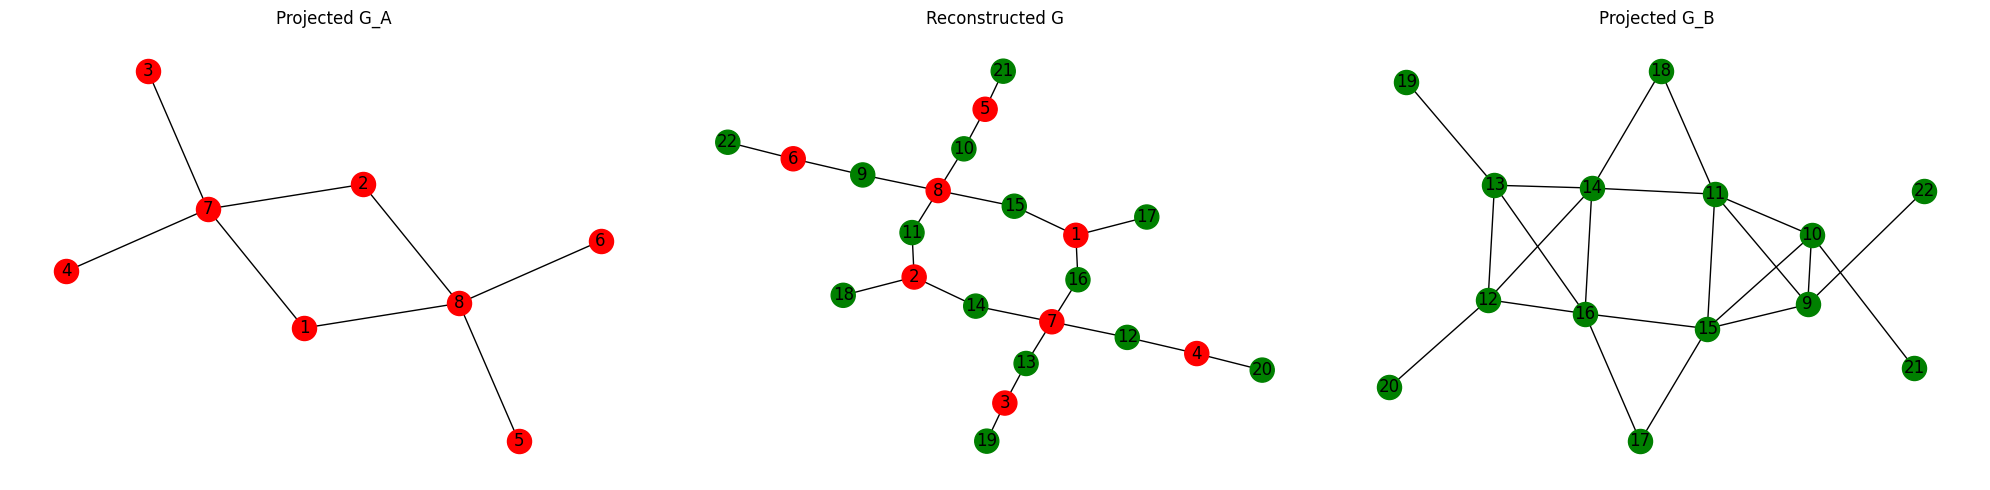

In [746]:
index = planar_indices[0]  # solution_indices[0]
index = next(planar_iter)
G_A_projected = M_colorable[index]  # Take one of the two-colorable graphs

G_rebuilt, G_A, G_B = construct_bipartite_graph(
    G_A_projected, max_degree_A=max_degree_A, max_degree_B=max_degree_B
)
if G_rebuilt:
    plot_graphs(G_rebuilt, G_A, G_B)

In [747]:
class TopologyMetric:
    def __init__(self, G):
        self.G = G

    def average_distance(self):
        """Computes the average shortest path length of a graph."""
        return nx.average_shortest_path_length(self.G)

    def graph_algebraic_connectivity(self):
        """Computes the algebraic connectivity of a graph."""
        L = nx.laplacian_spectrum(self.G)
        return -1.0 * L[1]  # Second smallest eigenvalue

    def diameter(self):
        return nx.diameter(self.G)


best_metric = float("inf")
for index in solution_indices:  # planar_indices:
    G_A_projected = M_colorable[index]  # Take one of the two-colorable graphs
    G_rebuilt, G_A, G_B = construct_bipartite_graph(
        G_A_projected, max_degree_A=max_degree_A, max_degree_B=max_degree_B
    )

    metrics = TopologyMetric(G_B)
    connectivity = metrics.graph_algebraic_connectivity()
    metric = connectivity

    if metric < best_metric:
        best_metric = metric
        best_index = index

print(f"Best index: {best_index}, Metric: {best_metric:.2f}")

Best index: 246, Metric: -4.00


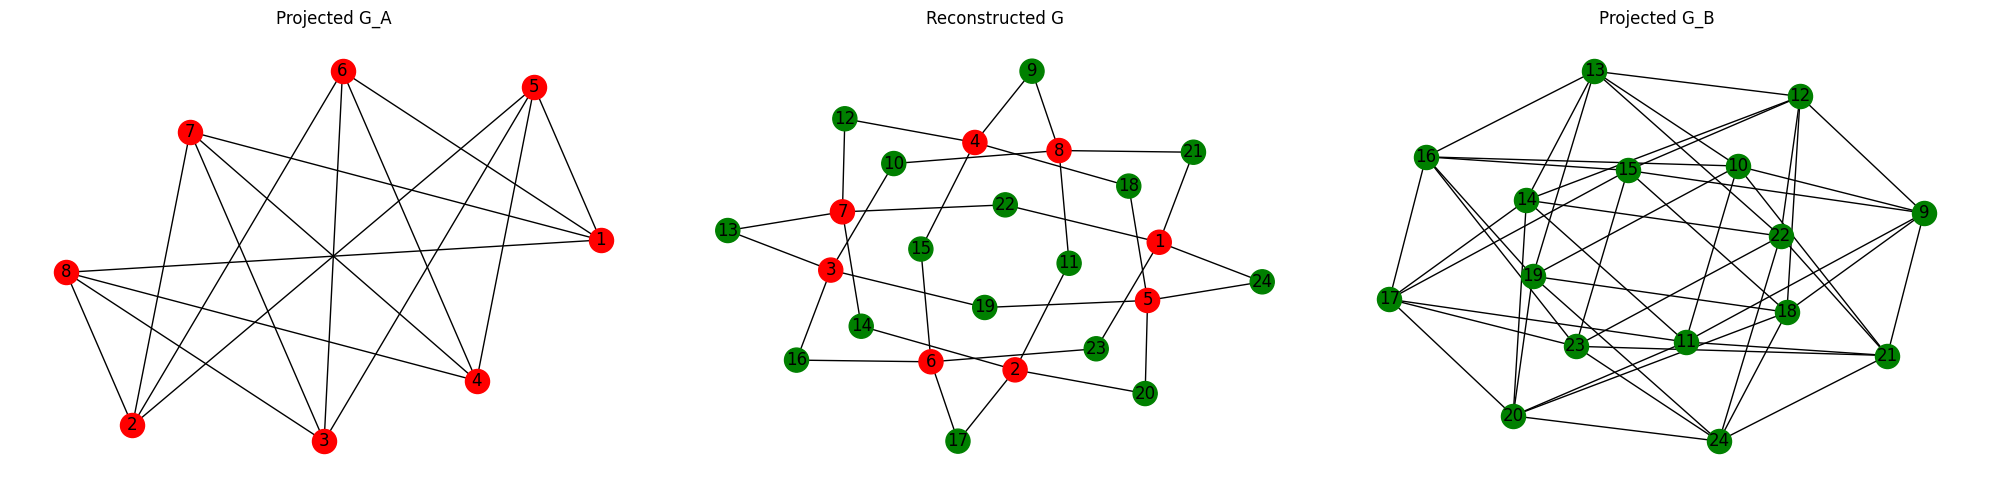

In [748]:
G_A_projected = M_colorable[best_index]  # Take one of the two-colorable graphs

G_rebuilt, G_A, G_B = construct_bipartite_graph(
    G_A_projected, max_degree_A=max_degree_A, max_degree_B=max_degree_B
)
if G_rebuilt:
    plot_graphs(G_rebuilt, G_A, G_B)